In [15]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import tifffile
import napari

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib_scalebar import scalebar as sb
from pyneurotrace import filters as pnf
from tqdm.notebook import trange, tqdm
from skimage import data, draw
from skimage.restoration import denoise_tv_chambolle
from skimage.registration import phase_cross_correlation
import skimage.measure as measure
from scipy import ndimage as ndi



In [16]:
%gui qt5
plt.rcParams['figure.facecolor'] = 'white'

In [17]:
# Change output figure size
# ...needs to be in its own cell for some reason...

plt.rcParams['figure.figsize'] = [16, 10]

In [18]:
def returnStimList(file):
    stim_csv = np.loadtxt(open(file), delimiter=',')
    print(stim_csv[0,:])
    stim_list = []
    seconds = np.array([3600, 60, 1])
    for i in range(1, stim_csv.shape[0], 1):
        temp= (stim_csv[i,3:] - stim_csv[0,3:])
        stim_list.append(np.sum(temp*seconds))
    return stim_list

# Returns change in fluorescence over average fluorescence of ROI
def returnROITrace(video, mask):
    video_mask = video * mask
    video_mask[video_mask==0] = np.nan
    trace = np.zeros(video.shape[0])
    for i in range(video_mask.shape[0]):
        trace[i] = np.nanmean(video_mask[i, :, :])
        
    return trace


In [23]:
# CONSTANTS AND FILES

# FRAME RATE
HZ = 44

# PIXEL VALUE IN REAL WORLD MEASUREMENTS
PX = .2


# PATH TO MOIVE FILE
FILE = '/mnt/5404b8a5-71b7-4464-9a1e-b40cd26fac58/Data_Drive/GluSnFr3_Project/GluSnfr3_210204/GPI/ROI2/Clip4/Test1_22_11_HZ_00013.tif'

# CSV FOR STIM TIME
STIM_FILE = '/mnt/5404b8a5-71b7-4464-9a1e-b40cd26fac58/Data_Drive/GluSnFr3_Project/GluSnfr3_210204/GPI/ROI2/Clip4/StimOutput02-04-2021 13-44.csv'


MOVIE = tifffile.imread(FILE)
print(MOVIE.shape)
if STIM_FILE is not None:
    STIM_LIST = returnStimList(STIM_FILE)

(8970, 50, 128)
[2.021e+03 2.000e+00 4.000e+00 1.300e+01 4.200e+01 1.077e+00]


In [20]:
# VIEW THE MOVIE
viewer = napari.Viewer()
viewer.add_image(MOVIE)

<Image layer 'MOVIE' at 0x7f2d948e1f28>

In [21]:
# SMOOTH TO HELP STABILIZE IT
smooth_movie = np.zeros(MOVIE.shape)
for i in trange(MOVIE.shape[0]):
    smooth_movie[i,:,:] = denoise_tv_chambolle(MOVIE[i,:,:], weight=.0005)

viewer = napari.Viewer()
viewer.add_image(smooth_movie)

<Image layer 'smooth_movie' at 0x7f2d32d50da0>

In [22]:
# CODE TO STABALIZE THE IMAGE USING PHASE CORRELATION

Stable_Image = np.zeros(MOVIE.shape)
Stable_Image[0, : : ] = MOVIE[0, :, :]

# COMPARES FRAMES AND CALCULATES THE DRIFT
for i in trange(MOVIE.shape[0]-1):
    shift, error, diffphase = phase_cross_correlation(smooth_movie[i, :,:], smooth_movie[(i+1),:,:], upsample_factor=100)
    # IF THE SHIFT IS GREATE THAN ZERO PIXELS APPLY A SHIFT TO THE ARRAY
    if (shift[0]> 0) or (shift[1] > 0):
        shifted_frame = ndi.interpolation.shift(MOVIE[(i+1),:,:], shift)
        Stable_Image[i+1, :,:] = shifted_frame
    else:
        Stable_Image[i+1, :,:] = MOVIE[(i+1),:,:]

In [24]:
# VIEW THE MOVIE, DETERMINE THE LAST FRAME BEFORE DRIFT IS TOO CRAZY
viewer = napari.Viewer()
viewer.add_image(Stable_Image)

<Image layer 'Stable_Image' at 0x7f2d3230aeb8>

In [25]:
# MANUALLY SET THE FRAMES TO PROCESS 
# SET AN INT FOR THE FIRST FRAME
FIRST_FRAME = 1500

# SET AN INT FOR THE LAST FRAME
LAST_FRAME = 3600

stable = Stable_Image[FIRST_FRAME:LAST_FRAME,:,:]
viewer = napari.Viewer()
viewer.add_image(stable)

if STIM_FILE is not None:
    stim2plot = []
    for stim in STIM_LIST:
        if (FIRST_FRAME/HZ) <= stim <= (LAST_FRAME/HZ):
            stim2plot.append(stim - (FIRST_FRAME/HZ))

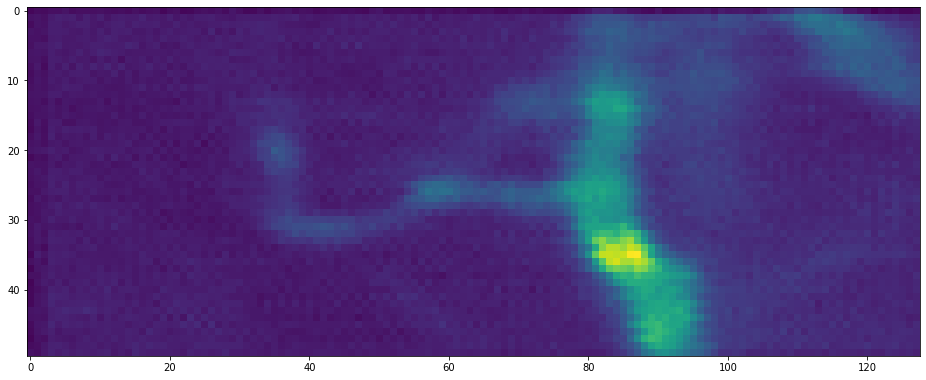

In [26]:
DENDRITE = np.std(stable, axis=0)
plt.imshow(DENDRITE)

In [29]:
# PAINT THE ROI IN THE NAPARI WINDOW
ROI = np.zeros(DENDRITE.shape)
roi_painter = napari.Viewer()
roi_painter.add_image(DENDRITE)
roi_painter.add_labels(ROI)


<Labels layer 'ROI' at 0x7f2d33512080>

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


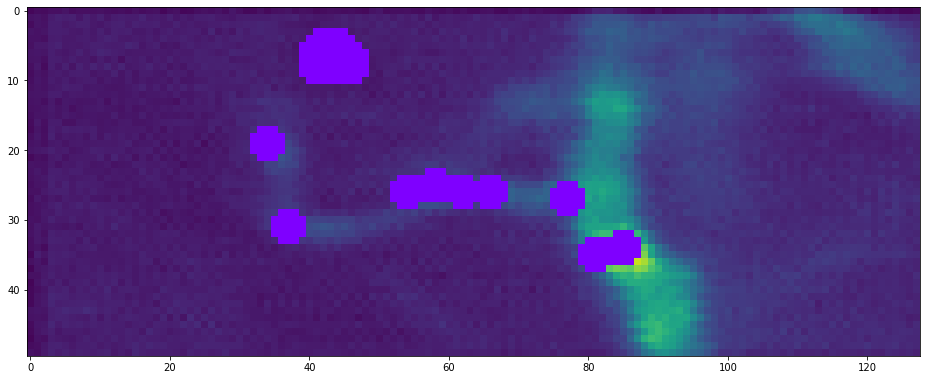

In [30]:
# DISPLAY THE IMAGING AREA AND ROIs
plt.imshow(DENDRITE)
ROI_LABLES = np.unique(ROI)
print(ROI_LABLES)
for roi in ROI_LABLES:
    if roi > 0:
        mask = ROI.copy()
        mask[mask!=roi] = np.nan      
        plt.imshow(mask, cmap='rainbow')

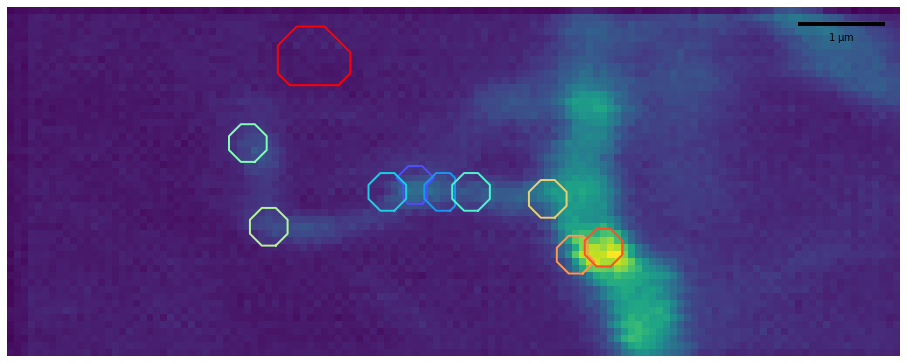

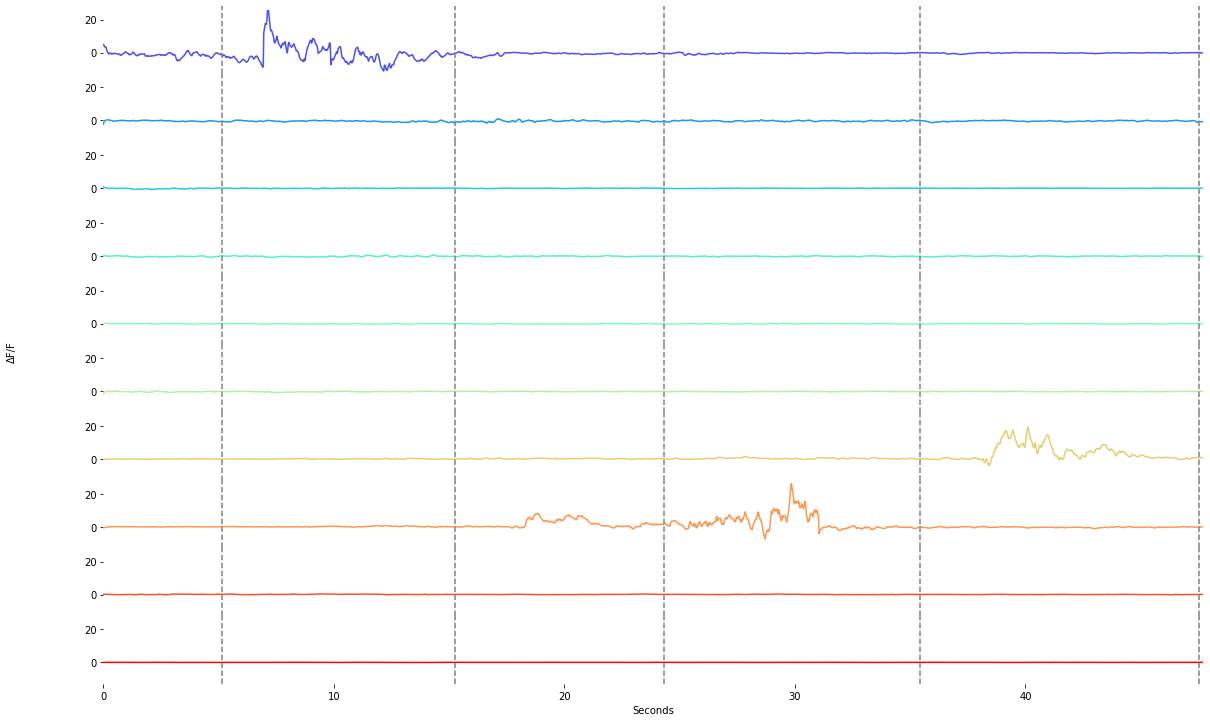

In [37]:
# PLOTS DF/F OF ROI OVER STD PROJECTION OF THE SAMPLE MOVIE

ROI_LABLES = np.unique(ROI)
rainbow = cm.get_cmap('rainbow', len(ROI_LABLES))
time = np.arange(stable.shape[0])/HZ

fig2, ax1 = plt.subplots()
ax1.axis("off")
scalebar = sb.ScaleBar(
    0.08,
    "um",
    box_color =None,
    box_alpha=0,
    length_fraction=0.1,
    scale_loc="bottom",
    border_pad=1,
    pad=.5
)
ax1.add_artist(scalebar)

fig, axs = plt.subplots((len(ROI_LABLES)-1), sharex=True,sharey=True, )
fig.tight_layout()
fig.text(-0.05,0.5, "ΔF/F", ha="center", va="center", rotation=90)
ax1.imshow(DENDRITE)
for roi in ROI_LABLES:
    if roi > 0:
        mask = ROI.copy()
        mask[mask!=roi] = 0
        mask[mask!=0] = 1
        
        # Return the average intensity value for the roi
        roi_trace = returnROITrace(stable, mask)
        # Remove shot noise
        roi_trace = pnf.okada(roi_trace)
        # Calculate Df/F
        roi_trace = pnf.deltaFOverF0(roi_trace, HZ)
        contour = measure.find_contours(mask, .3)
        ax1.plot(contour[0][:, 1],contour[0][:, 0], linewidth=2, color=rainbow(roi/ROI_LABLES.max()))
        axs[int(roi)-1].plot(time,roi_trace, color=rainbow(roi/ROI_LABLES.max()))
        axs[int(roi)-1].set_xlim([0,np.max(time)])
        if STIM_FILE is not None:
            for stim in stim2plot:
                axs[int(roi)-1].axvline(x=(stim), ls='--', color='grey')
        axs[int(roi)-1].spines['top'].set_visible(False)
        axs[int(roi)-1].spines['right'].set_visible(False)
        axs[int(roi)-1].spines['bottom'].set_visible(False)
        axs[int(roi)-1].spines['left'].set_visible(False)
        if int(roi) == (len(ROI_LABLES)-1):
            axs[int(roi)-1].set_xlabel('Seconds')
        else:
            axs[int(roi)-1].xaxis.set_ticks_position('none')

plt.subplots_adjust(wspace=0, hspace=0)
 
        